# **Chapter 8**
## *Outlier Detection Using Statistical Methods*, 

This chapter covers statistical methods for outlier and anomaly detection. These practical yet straightforward techniques are easy to interpret and implement. The chapter uses data from the **Numenta Anomaly Benchmark (NAB)** to evaluate different anomaly detection algorithms.

The recipes that you will encounter in this chapter are as follows:  
* Resampling time series data
* Detecting outliers using visualizations
* Detecting outliers using the Tukey method
* Detecting outliers using a z-score
* Detecting outliers using a modified z-score

# -- START --

* If you have the libraries installed check the versions 
* If the libraries are missing or you have an older version then either install or update the library

# Technical Requirements 
* Preparing for the recipes of this chapter

In [1]:
import matplotlib 
import pandas as pd
import scipy 
import statsmodels

print(f'''
matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
scipy -> {scipy.__version__}
statsmodels -> {statsmodels.__version__}
''')


matplotlib -> 3.10.6
pandas -> 2.3.3   
scipy -> 1.16.2
statsmodels -> 0.14.5



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# import warnings

# warnings.filterwarnings('ignore')
# plt.rcParams["figure.figsize"] = [16, 3]

In [3]:
plt.rcParams["figure.figsize"] = [12, 5]  
# plt.style.use('grayscale')

### Create DataFrames 

In [4]:
file = Path("../../datasets/Ch8/nyc_taxi.csv")
nyc_taxi = pd.read_csv(file,
                    index_col='timestamp',
                    parse_dates=True)

nyc_taxi.index.freq = '30min'

In [5]:
from utils import plot_outliers, plot_zscore


### Visualize DataFrames

* **nyc_taxi.csv**: Number of NYC taxi passengers, where the five anomalies occur during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm. The raw data is from the NYC Taxi and Limousine Commission. The data file included here consists of aggregating the total number of taxi passengers into 30 minute buckets.

The New York Taxi dataset captures the number of NYC taxi passengers at a specific timestamp. The data contains known anomalies that are provided to evaluate the performance of our outlier detectors. The dataset contains 10,320 records between July 1, 2014, to May 31, 2015. The observations are captured in a 30-minute interval, which translates to freq = '30T'.

In [6]:
nyc_taxi.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq='30min')

In [7]:
nyc_dates =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]

If you investigate these dates to gain more insight into their significance, you will find similar information to the following summary:
* Saturday, November 1, 2014, was before the New York Marathon, and the official marathon event was on Sunday, November 2, 2014.
* Thursday, November 27, 2014, was Thanksgiving Day.
* Thursday, December 25, 2014, was Christmas Day.
* Thursday, January 1, 2015, was New Year's Day.
* Tuesday, January 27, 2015, was the North American Blizzard where all vehicles were ordered off the street from January 26 to January 27, 2015.

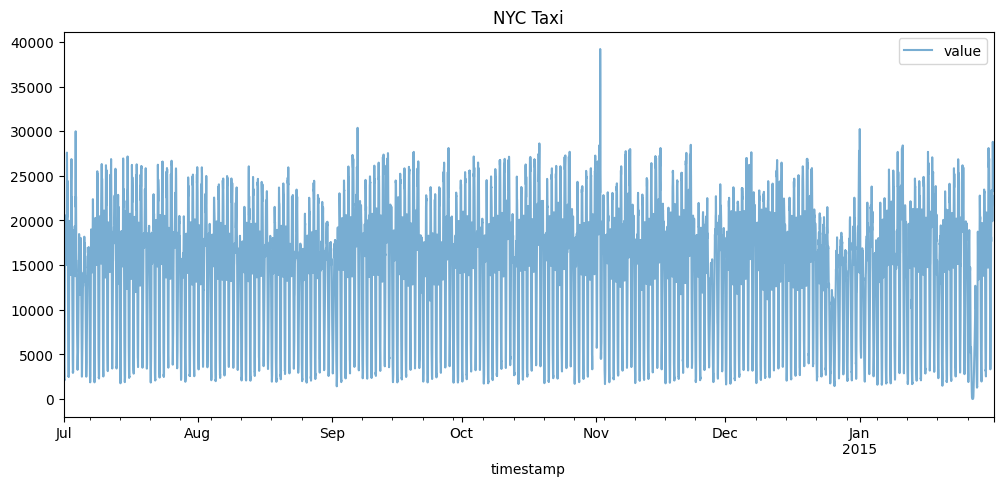

In [8]:
nyc_taxi.plot(title="NYC Taxi", alpha=0.6);

In [9]:
nyc_taxi.index.freq = '30min'

In [10]:
nyc_taxi.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq='30min')

In [11]:
tx = nyc_taxi.resample('D').mean()

In [12]:
known_outliers = tx.loc[nyc_dates]

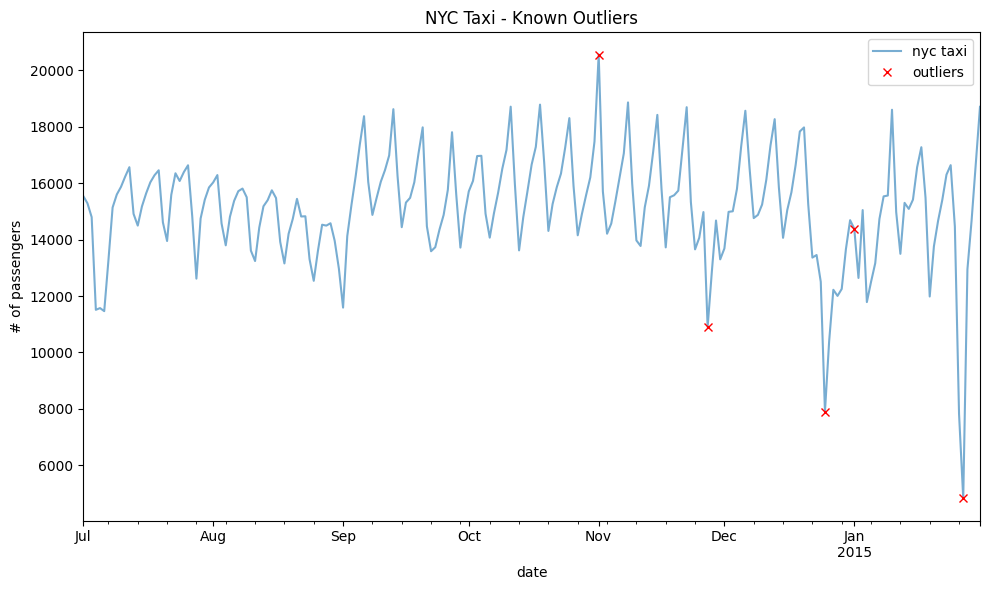

In [13]:
plot_outliers(known_outliers, tx, 'Known Outliers')

# Recipe 1. Resampling Time Series Data
* Learn about upsampling
* Learn about downsampling

In [14]:
print(nyc_taxi.head())

                     value
timestamp                 
2014-07-01 00:00:00  10844
2014-07-01 00:30:00   8127
2014-07-01 01:00:00   6210
2014-07-01 01:30:00   4656
2014-07-01 02:00:00   3820


In [15]:
print(nyc_taxi.index.freq)

<30 * Minutes>


In [16]:
df_downsampled = nyc_taxi.resample('D').mean()
print(df_downsampled.head())

                   value
timestamp               
2014-07-01  15540.979167
2014-07-02  15284.166667
2014-07-03  14794.625000
2014-07-04  11511.770833
2014-07-05  11572.291667


In [17]:
print(df_downsampled.index.freq)

<Day>


In [18]:
df_downsampled.shape

(215, 1)

In [19]:
df_downsampled = nyc_taxi.resample('3D').sum()
print(df_downsampled.head())

              value
timestamp          
2014-07-01  2189749
2014-07-04  1658320
2014-07-07  2111672
2014-07-10  2335629
2014-07-13  2139711


In [20]:
df_downsampled.shape

(72, 1)

In [21]:
print(df_downsampled.index.freq)

<3 * Days>


In [22]:
df_downsampled = nyc_taxi.resample('3B').sum()
print(df_downsampled.head())

              value
timestamp          
2014-07-01  2189749
2014-07-04  3021425
2014-07-09  3799847
2014-07-14  2174540
2014-07-17  3711232


In [23]:
df_upsampled = nyc_taxi.resample('15min').mean()
print(df_upsampled.head())

                       value
timestamp                   
2014-07-01 00:00:00  10844.0
2014-07-01 00:15:00      NaN
2014-07-01 00:30:00   8127.0
2014-07-01 00:45:00      NaN
2014-07-01 01:00:00   6210.0


In [24]:
# Using .mean(), .sum(), .min(), or .max()
df_upsampled = nyc_taxi.resample('15min').sum()
print(df_upsampled.head())

df_upsampled = nyc_taxi.resample('15min').mean()
print(df_upsampled.head())

df_upsampled = nyc_taxi.resample('15min').min()
print(df_upsampled.head())

df_upsampled = nyc_taxi.resample('15min').max()
print(df_upsampled.head())


                     value
timestamp                 
2014-07-01 00:00:00  10844
2014-07-01 00:15:00      0
2014-07-01 00:30:00   8127
2014-07-01 00:45:00      0
2014-07-01 01:00:00   6210
                       value
timestamp                   
2014-07-01 00:00:00  10844.0
2014-07-01 00:15:00      NaN
2014-07-01 00:30:00   8127.0
2014-07-01 00:45:00      NaN
2014-07-01 01:00:00   6210.0
                       value
timestamp                   
2014-07-01 00:00:00  10844.0
2014-07-01 00:15:00      NaN
2014-07-01 00:30:00   8127.0
2014-07-01 00:45:00      NaN
2014-07-01 01:00:00   6210.0
                       value
timestamp                   
2014-07-01 00:00:00  10844.0
2014-07-01 00:15:00      NaN
2014-07-01 00:30:00   8127.0
2014-07-01 00:45:00      NaN
2014-07-01 01:00:00   6210.0


In [25]:
# nyc_taxi.resample('15T').fillna('ffill').head()
df_upsampled = nyc_taxi.resample('15min').ffill()
print(df_upsampled.head())


                     value
timestamp                 
2014-07-01 00:00:00  10844
2014-07-01 00:15:00  10844
2014-07-01 00:30:00   8127
2014-07-01 00:45:00   8127
2014-07-01 01:00:00   6210


In [26]:
print(nyc_taxi.resample('15min').ffill().head())

                     value
timestamp                 
2014-07-01 00:00:00  10844
2014-07-01 00:15:00  10844
2014-07-01 00:30:00   8127
2014-07-01 00:45:00   8127
2014-07-01 01:00:00   6210


In [27]:
nyc_taxi.resample('15min').ffill()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:15:00,10844
2014-07-01 00:30:00,8127
2014-07-01 00:45:00,8127
2014-07-01 01:00:00,6210
...,...
2015-01-31 22:30:00,27309
2015-01-31 22:45:00,27309
2015-01-31 23:00:00,26591


## There is more

In [28]:
print(nyc_taxi.resample('M').agg(['mean', 
                             'min', 
                             'max', 
                             'median', 
                             'sum']))

                   value                                
                    mean   min    max   median       sum
timestamp                                               
2014-07-31  14994.084677  1769  29985  16625.5  22311198
2014-08-31  14580.438844  1841  26062  16184.0  21695693
2014-09-30  15623.374306  1431  30373  17244.5  22497659
2014-10-31  16086.851478  1691  28626  17767.5  23937235
2014-11-30  15492.125000  1683  39197  17287.0  22308660
2014-12-31  14813.428763  1459  27804  16587.0  22042382
2015-01-31  14399.790995     8  30236  16061.0  21426889


/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_60535/3273461763.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  print(nyc_taxi.resample('M').agg(['mean',


In [29]:
print(nyc_taxi.resample('ME').agg(['mean', 
                             'min', 
                             'max', 
                             'median', 
                             'sum']))

                   value                                
                    mean   min    max   median       sum
timestamp                                               
2014-07-31  14994.084677  1769  29985  16625.5  22311198
2014-08-31  14580.438844  1841  26062  16184.0  21695693
2014-09-30  15623.374306  1431  30373  17244.5  22497659
2014-10-31  16086.851478  1691  28626  17767.5  23937235
2014-11-30  15492.125000  1683  39197  17287.0  22308660
2014-12-31  14813.428763  1459  27804  16587.0  22042382
2015-01-31  14399.790995     8  30236  16061.0  21426889


In [30]:
print(nyc_taxi.resample('MS').agg(['mean', 
                             'min', 
                             'max', 
                             'median', 
                             'sum']))

                   value                                
                    mean   min    max   median       sum
timestamp                                               
2014-07-01  14994.084677  1769  29985  16625.5  22311198
2014-08-01  14580.438844  1841  26062  16184.0  21695693
2014-09-01  15623.374306  1431  30373  17244.5  22497659
2014-10-01  16086.851478  1691  28626  17767.5  23937235
2014-11-01  15492.125000  1683  39197  17287.0  22308660
2014-12-01  14813.428763  1459  27804  16587.0  22042382
2015-01-01  14399.790995     8  30236  16061.0  21426889


In [31]:
result = nyc_taxi.resample('ME').agg(['mean', 
                                      'min', 
                                      'max', 
                                      'median', 
                                      'sum'])
# Rename the columns
result.columns = ['mean', 'min', 'max', 'median', 'sum'] 
print(result)

                    mean   min    max   median       sum
timestamp                                               
2014-07-31  14994.084677  1769  29985  16625.5  22311198
2014-08-31  14580.438844  1841  26062  16184.0  21695693
2014-09-30  15623.374306  1431  30373  17244.5  22497659
2014-10-31  16086.851478  1691  28626  17767.5  23937235
2014-11-30  15492.125000  1683  39197  17287.0  22308660
2014-12-31  14813.428763  1459  27804  16587.0  22042382
2015-01-31  14399.790995     8  30236  16061.0  21426889


# Recipe 2. Detecting Outliers using Visualization

* You will be using the nyc_taxi DataFrame that you loaded earlier in the Technical requirements section. 
* You will be using seaborn version 0.11.2, which is the latest version as of this writing.

    * To install seaborn using `pip`, use the following: 
    
    
    ```
    pip install seaborn
    ```
    
    * To install seaborn using `conda`, use the following:  
    
    
    ```
    conda install seaborn
    ```

In [32]:
import seaborn as sns
sns.__version__

'0.13.2'

In [33]:
known_outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


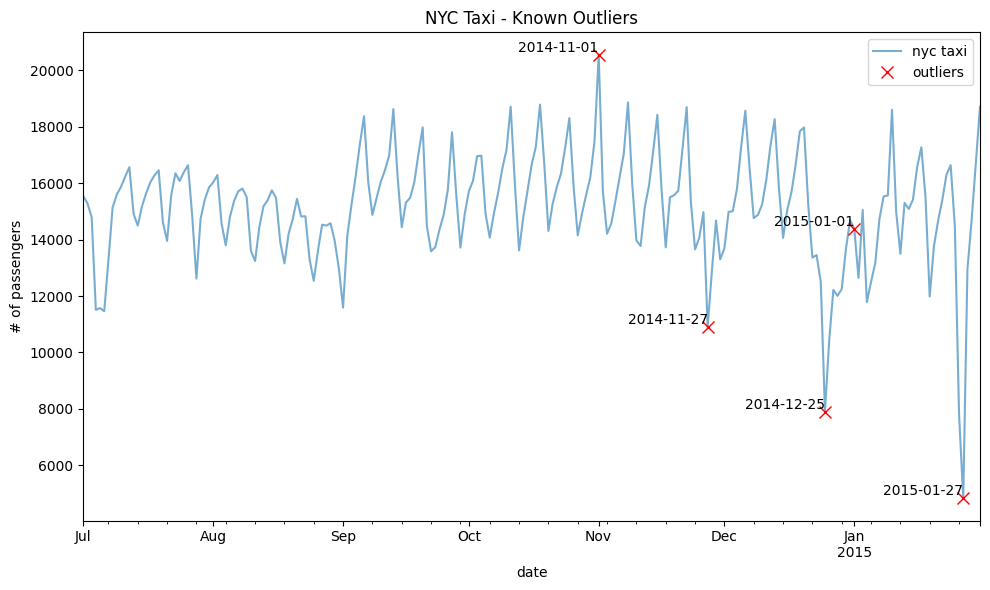

In [34]:
tx = nyc_taxi.resample('D').mean()
known_outliers= tx.loc[nyc_dates]
plot_outliers(known_outliers, tx, 'Known Outliers', labels=True)

## Histogram

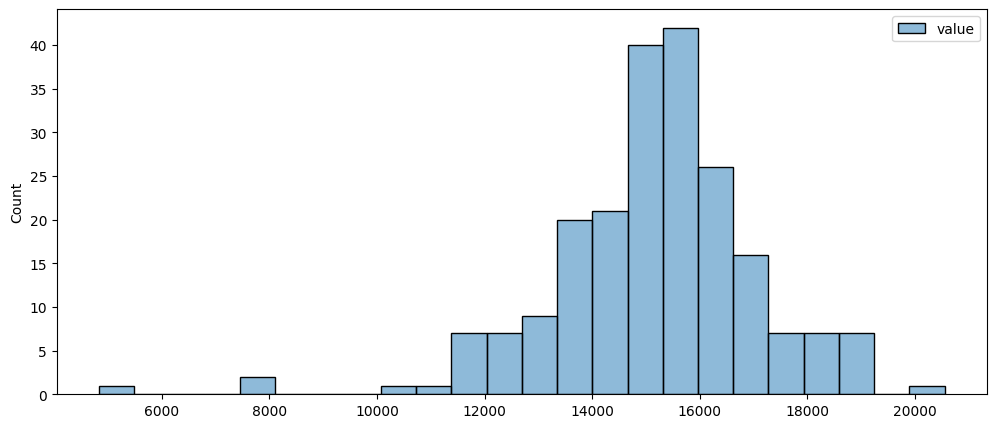

In [35]:
sns.histplot(tx);

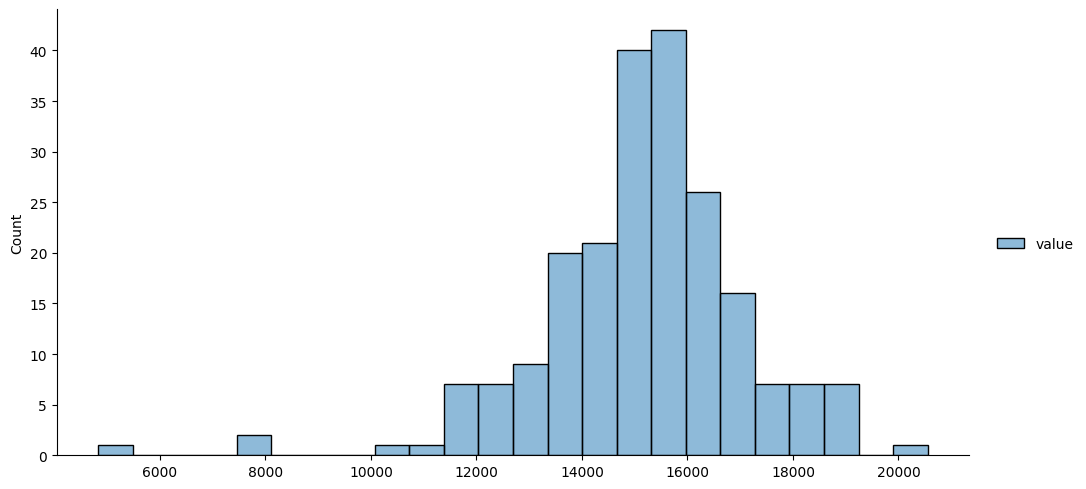

In [36]:
sns.displot(tx, kind='hist', height=5, aspect=2);

## Box Plot

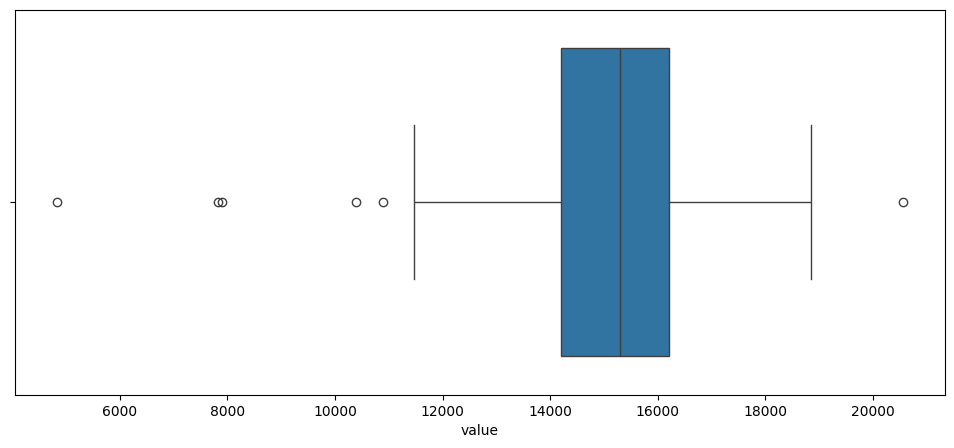

In [37]:
sns.boxplot(tx['value'], orient='h');

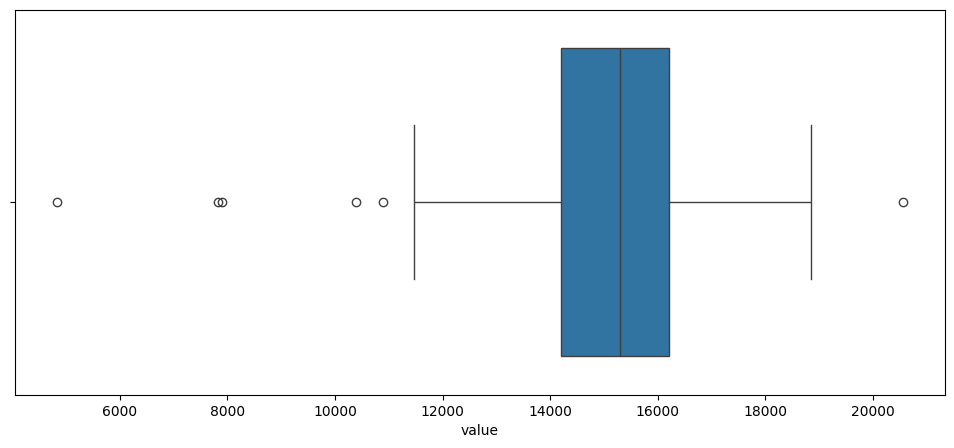

In [38]:
sns.boxplot(tx['value'], orient='h', whis=1.5);

## Boxen Plot (Letter Value)

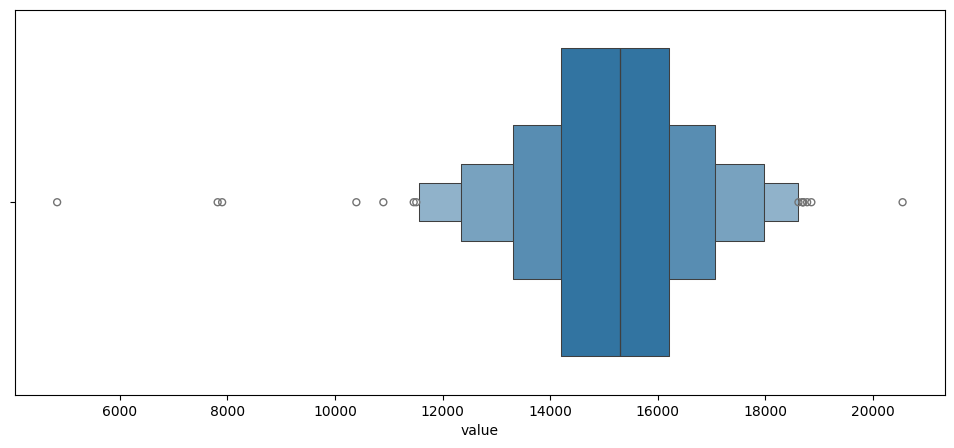

In [39]:
sns.boxenplot(tx['value'],orient='h');

<Axes: xlabel='value'>

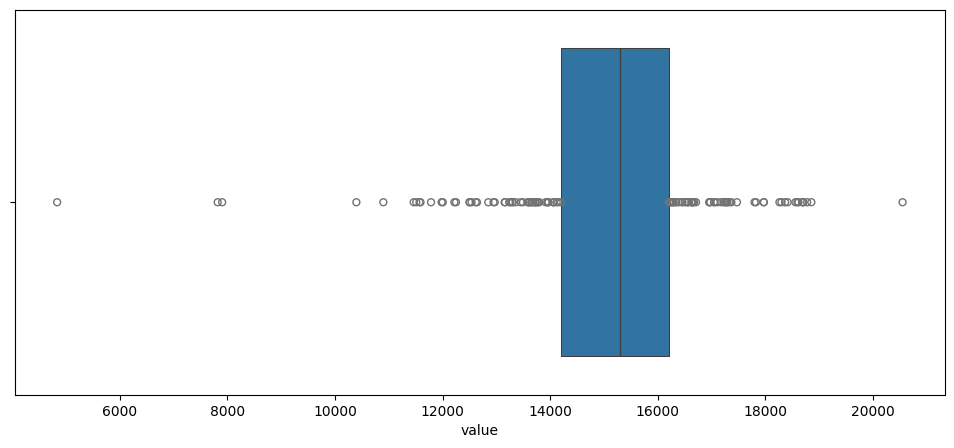

In [40]:
# changing depth with numeric value
sns.boxenplot(tx['value'], k_depth=1, orient='h') 

In [41]:
print(tx.describe())

              value
count    215.000000
mean   15137.569380
std     1937.391020
min     4834.541667
25%    14205.197917
50%    15299.937500
75%    16209.427083
max    20553.500000


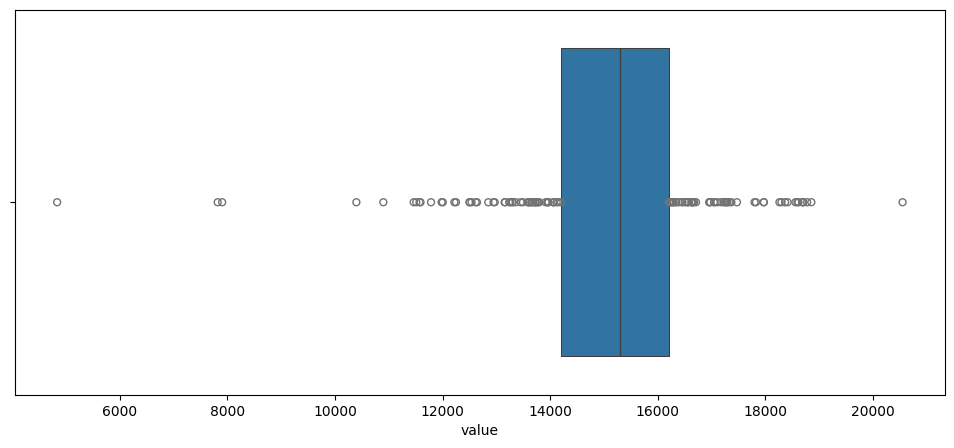

In [42]:
# changing depth with numeric value
sns.boxenplot(tx['value'], k_depth=1, orient='h');

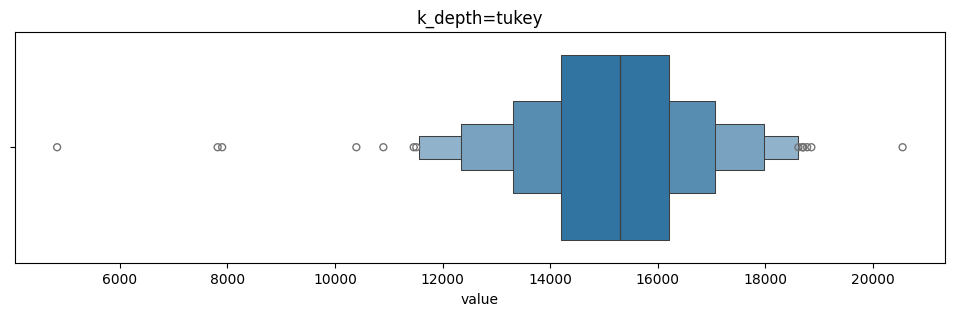

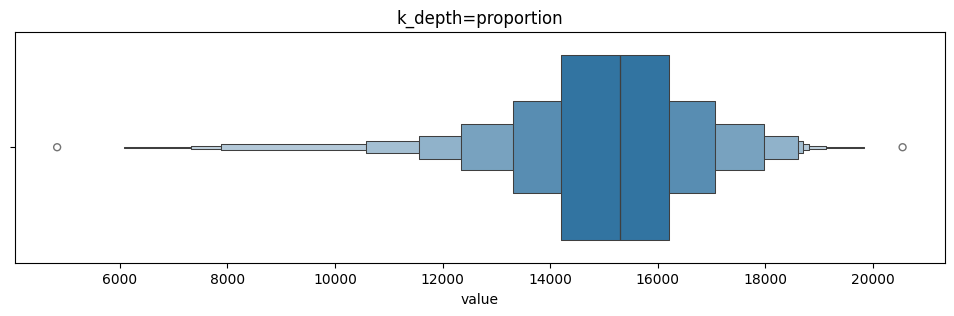

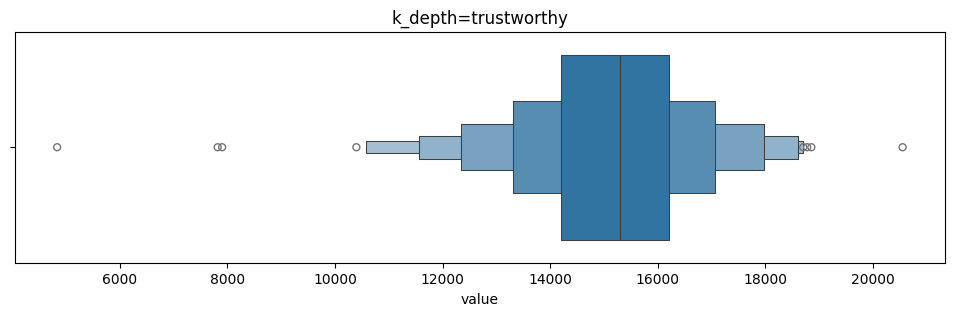

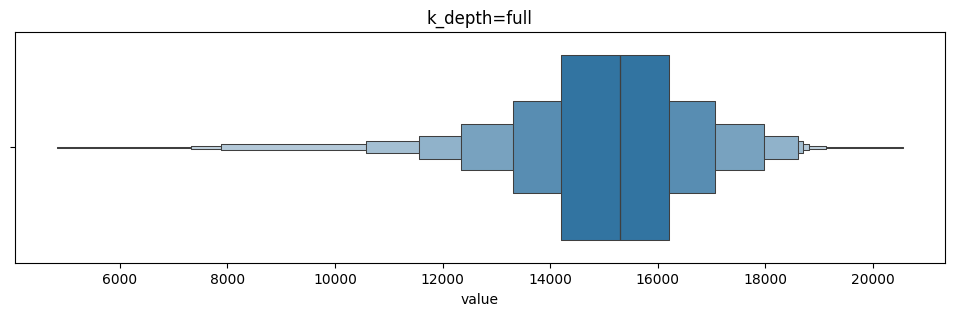

In [43]:
# exploring different methods 
for k in ["tukey", "proportion", "trustworthy", "full"]:
    plt.figure(figsize=(12, 3)) 
    sns.boxenplot(tx['value'], k_depth=k, orient='h')
    plt.title(f'k_depth={k}')
    plt.show()


## Violin Plot

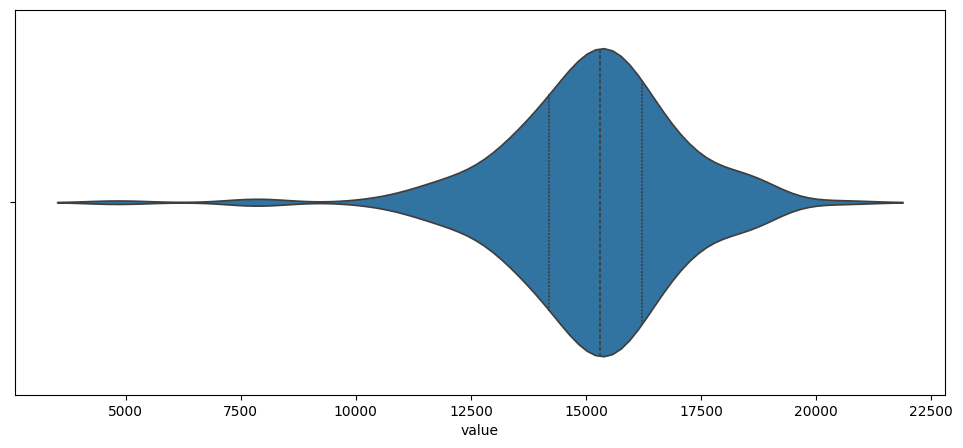

In [44]:
sns.violinplot(tx['value'], inner='quartile', orient='h');

## There is more

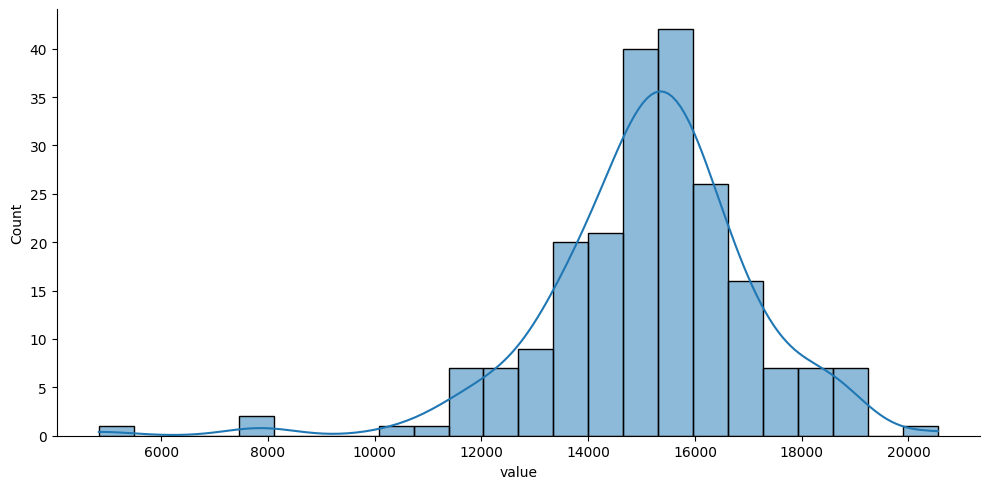

In [45]:
sns.displot(tx['value'], kind='hist', height=5, aspect=2, kde=True);

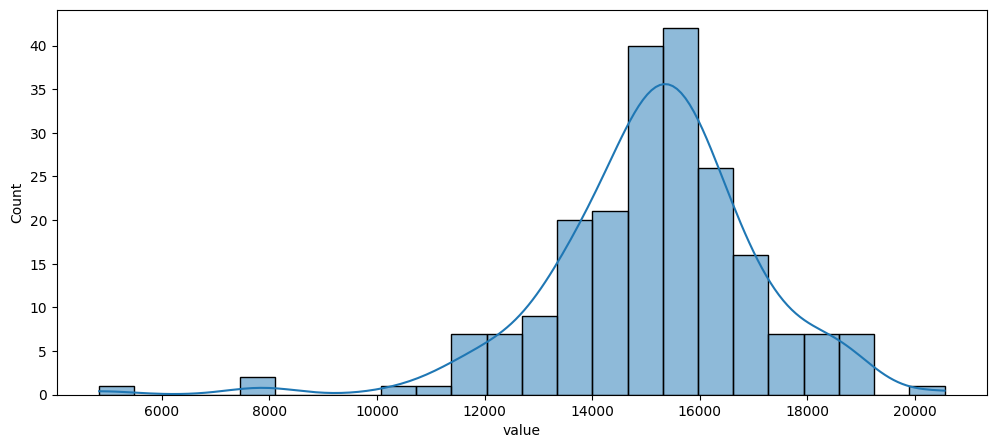

In [46]:
sns.histplot(tx['value'], kde=True);

### Lag Plot

In [47]:
from pandas.plotting import lag_plot

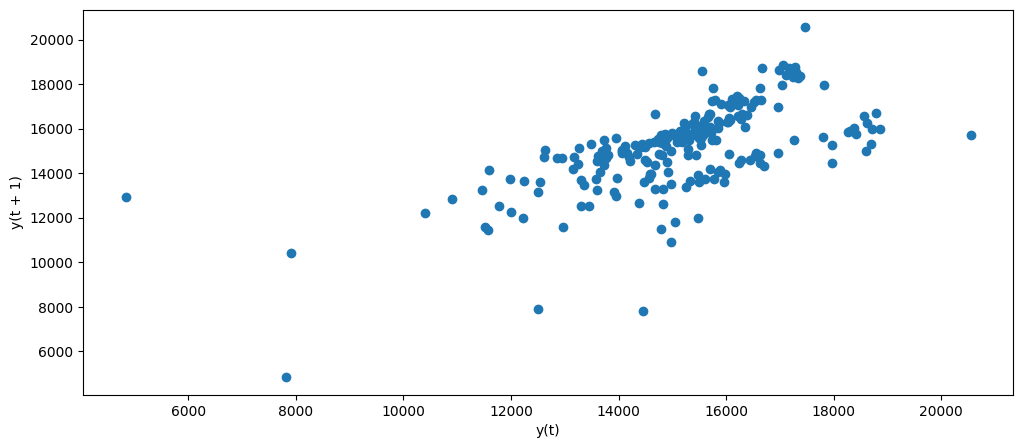

In [48]:
# default lag=1
lag_plot(tx['value'], lag=1);

Creating a Lag Plot using `seaborn.scatterplot`

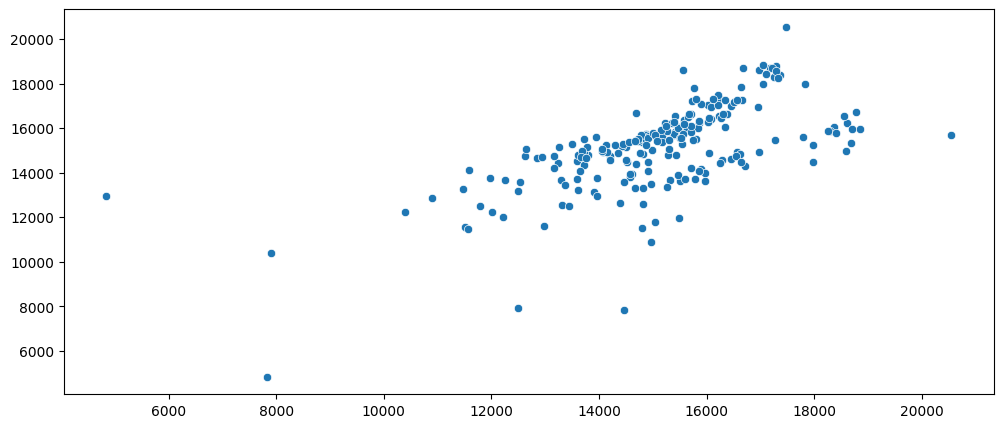

In [49]:
y = tx[1:].values.reshape(-1)
x = tx[:-1].values.reshape(-1)
sns.scatterplot(x=x, y=y);

# Recipe 3. Detecting Outliers using Tukey’s Method

Define the `iqr_outliers` functions

In [50]:
tx = nyc_taxi.resample('D').mean()
percentiles = [0, 0.05, .10, .25, .5, .75, .90, .95, 1]
tx.describe(percentiles= percentiles)

,value
count,215.000000
mean,15137.569380
std,1937.391020
min,4834.541667
0%,4834.541667
5%,11998.181250
10%,13043.854167
25%,14205.197917
50%,15299.937500
75%,16209.427083


In [51]:
percentiles = [0, 5, 10, 25, 50, 75, 90, 95, 100]
np.percentile(tx, percentiles)

array([ 4834.54166667, 11998.18125   , 13043.85416667, 14205.19791667,
       15299.9375    , 16209.42708333, 17279.3       , 18321.61666667,
       20553.5       ])

In [52]:
quantiles = [0, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 1]
np.quantile(tx, quantiles)

array([ 4834.54166667, 11998.18125   , 13043.85416667, 14205.19791667,
       15299.9375    , 16209.42708333, 17279.3       , 18321.61666667,
       20553.5       ])

In [53]:
def iqr_outliers(data, k):
    """
    Detect outliers using Tukey's method with customizable fence multiplier.
    
    Parameters:
    data (DataFrame): Time series data with a 'value' column
    k (float): The fence multiplier to use (typically 1.5)
    
    Returns:
    DataFrame: Filtered data containing only outlier points
    """
    q1, q3 = np.percentile(data, [25, 75])
    IQR = q3 - q1
    lower_fence = q1 - (k * IQR)
    upper_fence = q3 + (k * IQR)
    return data[(data.value > upper_fence) | (data.value < lower_fence)]

In [54]:
outliers = iqr_outliers(tx, 1.5)
print(outliers)

                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


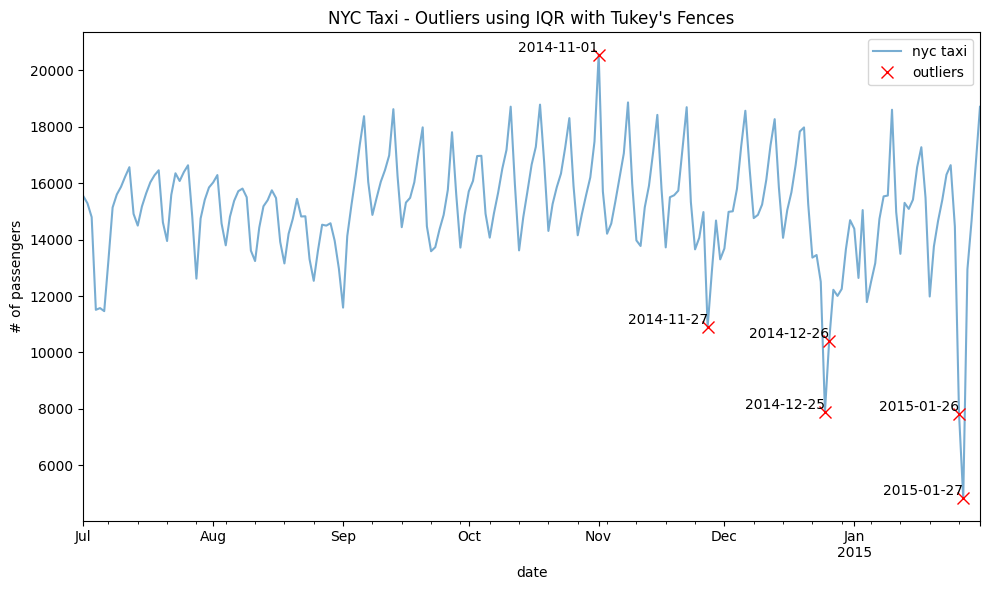

In [55]:
plot_outliers(outliers, tx, "Outliers using IQR with Tukey's Fences", labels=True)

In [56]:
known_outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


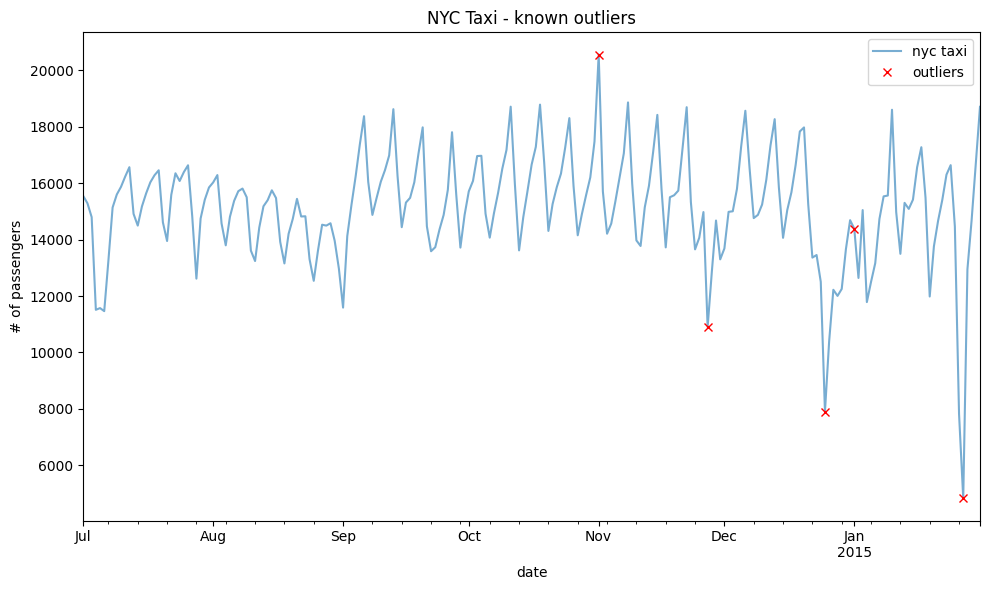

In [57]:
plot_outliers(known_outliers, tx, "known outliers")

## There is more

In [58]:
for k in [1.3, 1.5, 2.0, 2.5,  3.0]:
    print(f'using k={k}')
    print(iqr_outliers(tx, k))
    print('-'*25)

using k=1.3
                   value
timestamp               
2014-07-04  11511.770833
2014-07-05  11572.291667
2014-07-06  11464.270833
2014-09-01  11589.875000
2014-11-01  20553.500000
2014-11-08  18857.333333
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
-------------------------
using k=1.5
                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
-------------------------
using k=2.0
                   value
timestamp               
2014-11-01  20553.500000
2014-12-25   7902.125000
2015-01-26   7818.979167
2015-01-27   4834.541667
-------------------------
using k=2.5
                  value
timestamp              
2014-12-25  7902.125000
2015-01-26  7818.979167
2015-01-27  4834.541667
-------------------------
using k=3.0
                  value
timestamp        

# Recipe 4. Detecting Outliers with Z-score
* What is Z-Score
* Assumptions for Z-Score
* How it is used for Outlier/Anomaly Detection

**Z-Scores**

$$
\Large z = \frac{x - \mu}{\sigma}
$$

In [59]:
def zscore(df, threshold=3):
    """
    Detect outliers using z-score method with customizable threshold.
    
    Parameters:
    df (DataFrame): Time series data with a 'value' column
    threshold (float): The threshold in standard deviations (typically 2-3)
    
    Returns:
    tuple: (outliers DataFrame, transformed DataFrame with z-scores)
    """
    data = df.copy()
    data['zscore'] = (data - data.mean())/data.std()
    outliers = data[(data['zscore'] <= -threshold) | (data['zscore'] >= threshold)]
    
    return outliers, data

In [60]:
tx = nyc_taxi.resample('D').mean()
threshold = 2.5
outliers, transformed = zscore(tx, threshold)

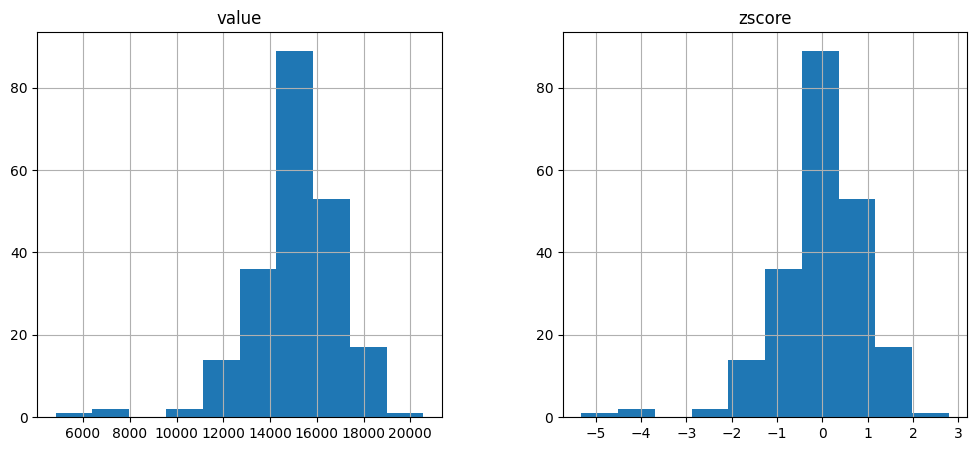

In [61]:
transformed.hist();

In [62]:
known_outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


In [63]:
print(outliers['value'])

timestamp
2014-11-01    20553.500000
2014-12-25     7902.125000
2015-01-26     7818.979167
2015-01-27     4834.541667
Name: value, dtype: float64


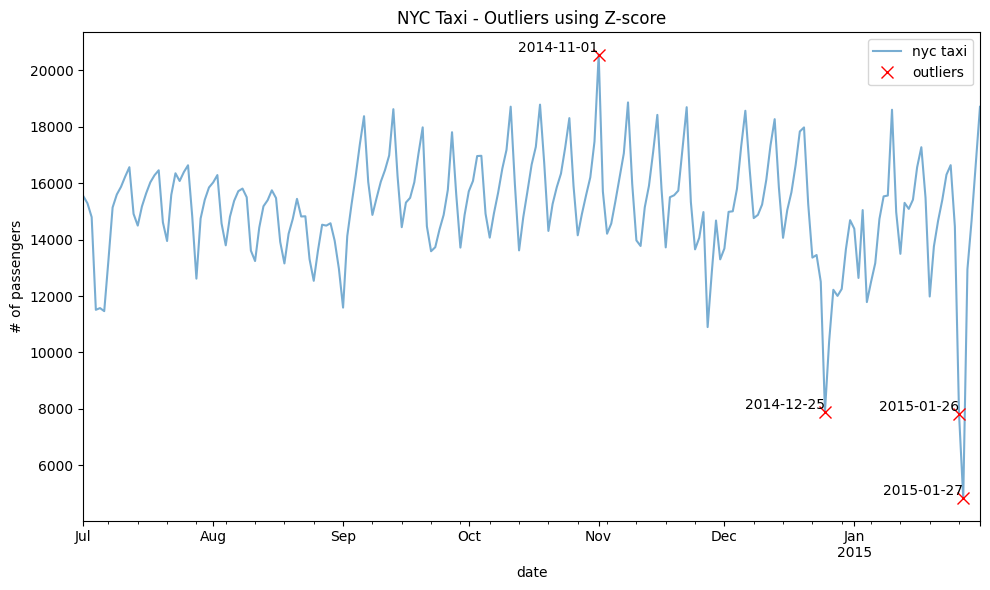

In [64]:
plot_outliers(outliers[['value']], tx, 'Outliers using Z-score', labels=True)

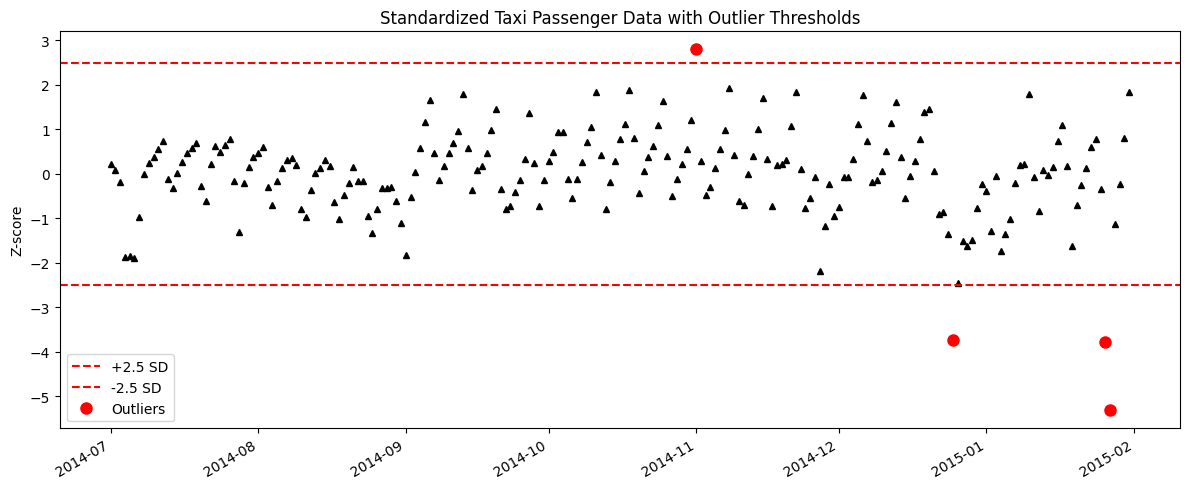

In [65]:
plot_zscore(transformed['zscore'], d=2.5)


In [66]:
outliers

,value,zscore
timestamp,,
2014-11-01,20553.500000,2.795476
2014-12-25,7902.125000,-3.734633
2015-01-26,7818.979167,-3.777549
2015-01-27,4834.541667,-5.317991


### There is more

In [67]:
from statsmodels.stats.diagnostic import kstest_normal

def test_normal(df):
    """
    Test if data follows a normal distribution using Kolmogorov-Smirnov test.
    
    Parameters:
    df (Series or array-like): Data to test for normality
    
    Returns:
    None: Prints whether to reject or fail to reject the null hypothesis
    """
    t_test, p_value = kstest_normal(df)
    if p_value < 0.05:
        print("Reject null hypothesis. Data is not normal")
    else:
        print("Fail to reject null hypothesis. Data is normal")

In [68]:
test_normal(tx)

Reject null hypothesis. Data is not normal


# Recipe 5. Modified Z-Score
* Understand the difference between Z-Score and Modified Z-Score
* When to use Modified Z-Score (and the assumptions behind Z-score)
* Scipy's Percent Point Function (PPF)

In [69]:
import scipy.stats as stats
stats.norm.ppf(0.75)

np.float64(0.6744897501960817)

In [70]:
import scipy.stats as stats
def modified_zscore(df, threshold=3):
    """
    Detect outliers using a modified z-score method with customizable threshold.
    
    Parameters:
    df (DataFrame): Time series data with a 'value' column
    threshold (float): The threshold in standard deviations (typically 2-3)
    
    Returns:
    tuple: (outliers DataFrame, transformed DataFrame with m_zscores)
    """
    data = df.copy()
    
    # Calculate median and MAD
    median = data['value'].median()
    MAD = np.median(np.abs(data['value'] - median))

    # Calculate modified z-score
    s = stats.norm.ppf(0.75)
    data['m_zscore'] = s * (data['value'] - median) / MAD
    # Identify outliers
    outliers = data[(data['m_zscore'] > threshold) | (data['m_zscore'] < -threshold)]
    
    return outliers, data

In [71]:
tx = nyc_taxi.resample('D').mean()
threshold =  3
outliers, transformed = modified_zscore(tx, threshold)

In [72]:
outliers.shape

(6, 2)

array([[<Axes: title={'center': 'value'}>,
        <Axes: title={'center': 'm_zscore'}>]], dtype=object)

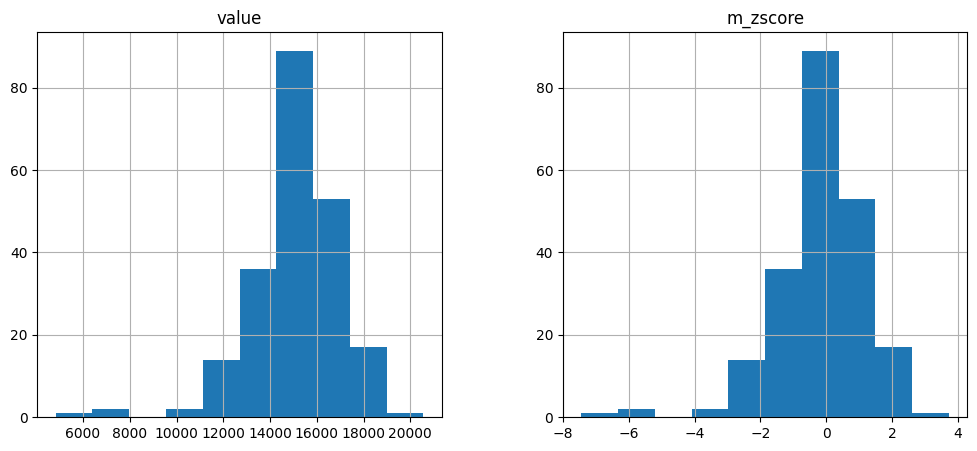

In [73]:
transformed.hist()

In [74]:
print(outliers['value'])

timestamp
2014-11-01    20553.500000
2014-11-27    10899.666667
2014-12-25     7902.125000
2014-12-26    10397.958333
2015-01-26     7818.979167
2015-01-27     4834.541667
Name: value, dtype: float64


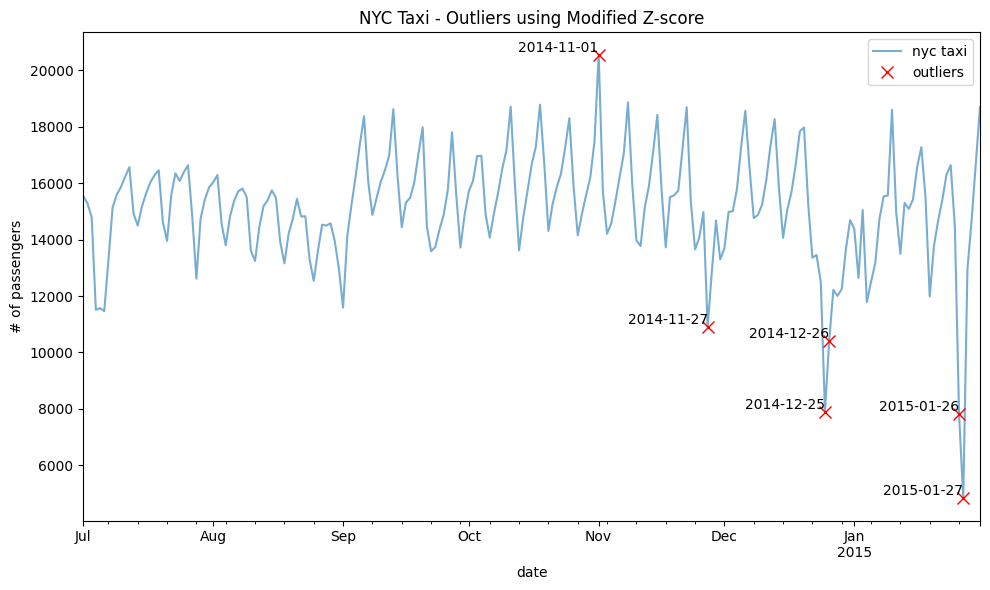

In [75]:
plot_outliers(outliers[['value']], tx, 'Outliers using Modified Z-score', labels=True)

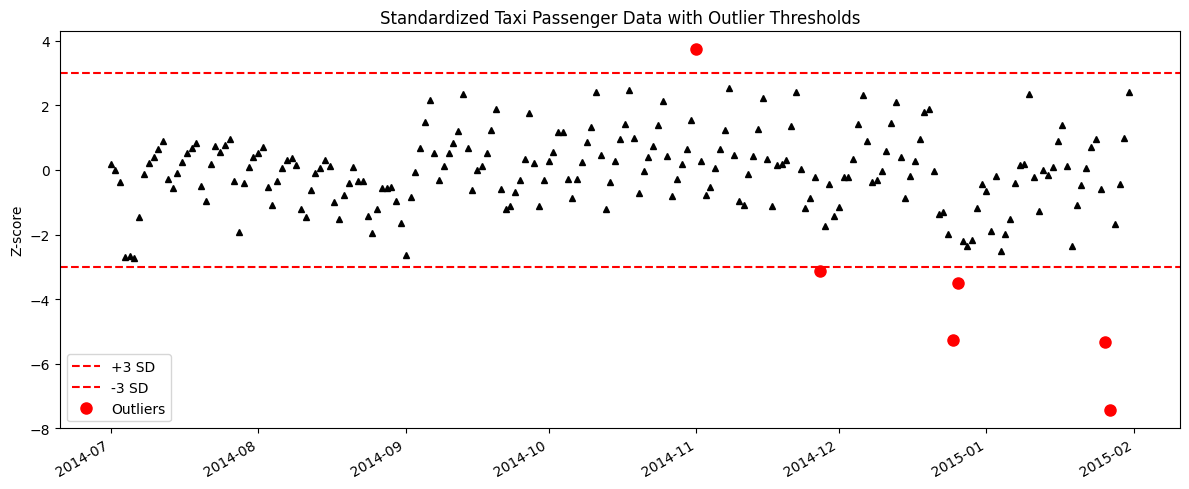

In [76]:
plot_zscore(transformed['m_zscore'], d=3)

## There is more

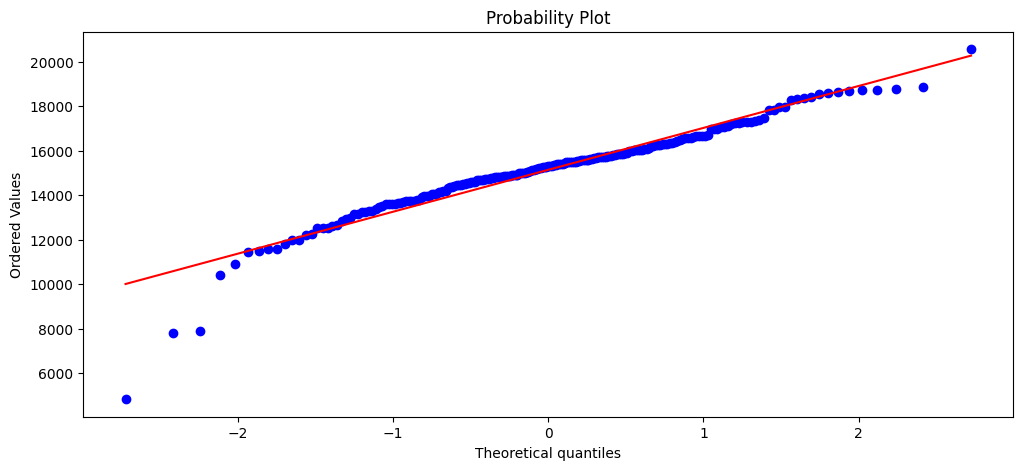

In [77]:
import scipy
import matplotlib.pyplot as plt
scipy.stats.probplot(tx['value'], plot=plt);

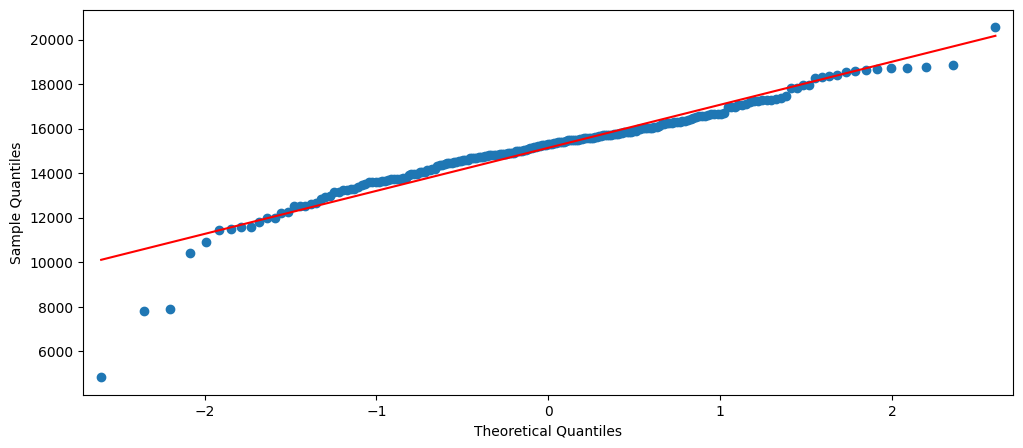

In [78]:
from statsmodels.graphics.gofplots import qqplot
qqplot(tx['value'], line='s');

# Recipe 6: Detecting outliers with Hampel Filter

In [79]:
from sktime.transformations.series.outlier_detection import HampelFilter

In [80]:
def hampel_outlier_detection(df, window_length=10, n_sigma=3):
    """
    Detect outliers using sktime's HampelFilter implementation.
    
    Parameters:
    df (DataFrame): Time series data with a 'value' column
    window_length (int): Size of the sliding window
    n_sigma (float): Number of standard deviations to use as threshold
    
    Returns:
    tuple: (outliers DataFrame, transformed DataFrame with filtered values)
    """
    # Create a copy of the input data
    data = df.copy()
    
    # Initialize the HampelFilter
    hampel = HampelFilter(
        window_length=window_length,
        n_sigma=n_sigma,
        k=1.4826,  # Default scale factor for Gaussian distribution
        return_bool=False  # Return NaN for outliers
    )
    
    # Apply the filter - this will return a series with NaN values at outlier positions
    data['filtered'] = hampel.fit_transform(data['value'])
    
    # Identify outliers (where transformed values are NaN)
    outliers = data[data['filtered'].isna()]
    
    return outliers, data

In [81]:
# Usage example
tx = nyc_taxi.resample('D').mean()

In [82]:
window_length = 21  # Adjust based on your data's seasonality
n_sigma = 2.5 
outliers, transformed = hampel_outlier_detection(tx, window_length, n_sigma)

In [83]:
print(outliers['value'])

timestamp
2014-07-04    11511.770833
2014-07-05    11572.291667
2014-07-06    11464.270833
2014-07-28    12615.854167
2014-11-01    20553.500000
2014-12-06    18561.625000
2014-12-25     7902.125000
2015-01-10    18597.166667
2015-01-26     7818.979167
2015-01-27     4834.541667
Name: value, dtype: float64


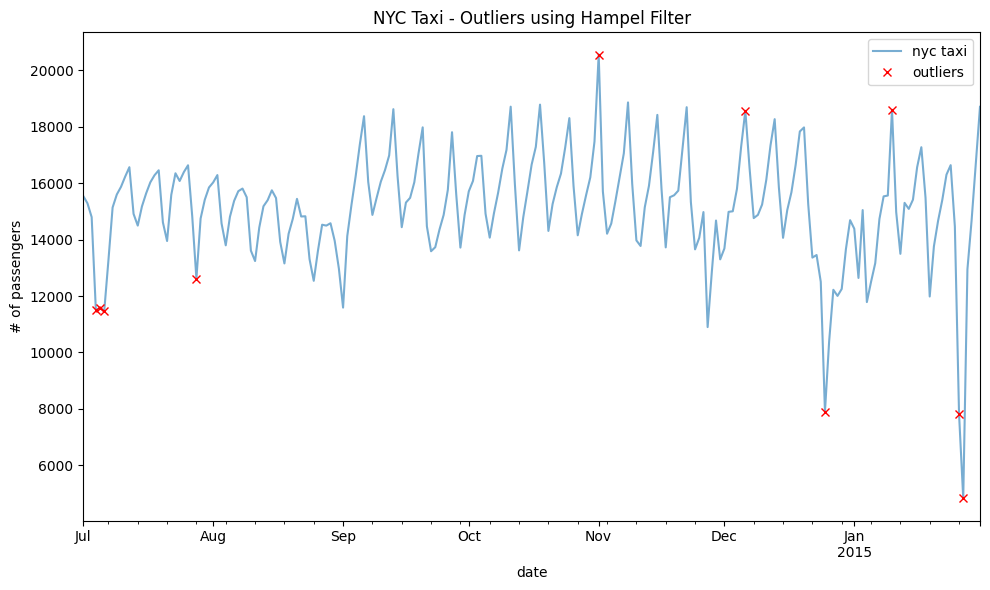

In [84]:
plot_outliers(outliers[['value']], tx, 'Outliers using Hampel Filter')

<Axes: xlabel='timestamp'>

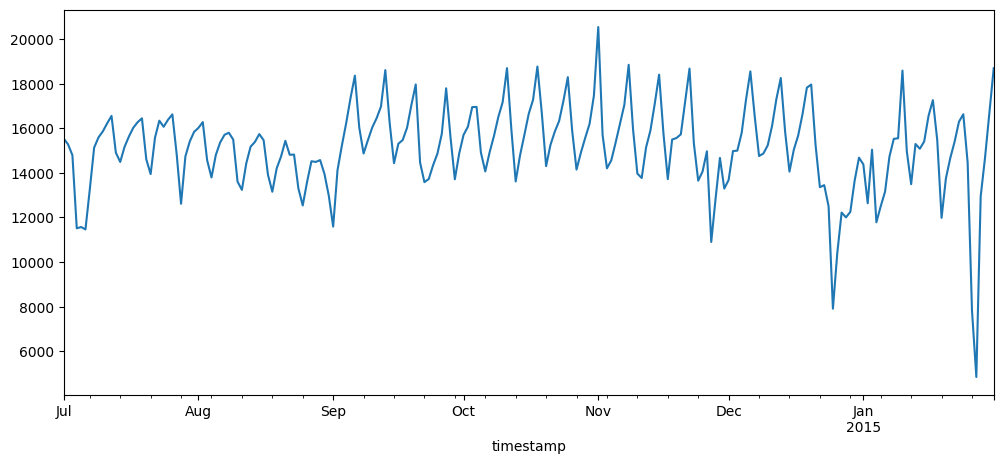

In [85]:
transformed['value'].plot()

## There is more

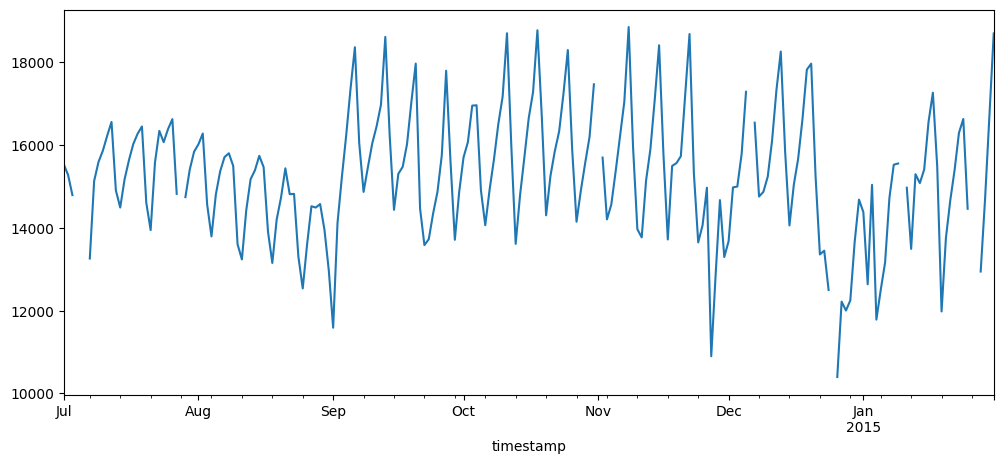

In [86]:
transformed['filtered'].plot();

In [87]:
from sktime.transformations.series.impute import Imputer

# Other options: "mean", "median", "nearest", etc.
imputer = Imputer(method="linear")  

# Fill in the missing values (former outliers)
y_corrected = imputer.fit_transform(transformed['filtered'])


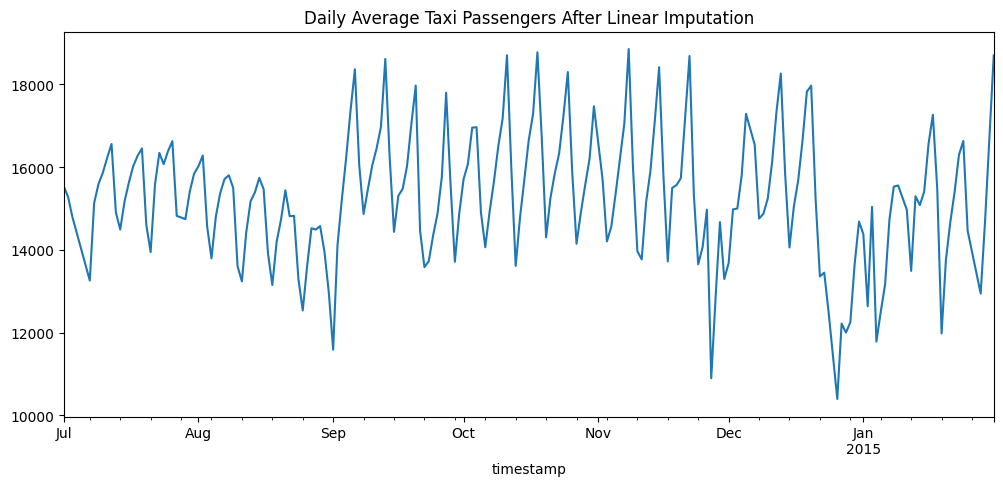

In [88]:
y_corrected.plot()
plt.title("Daily Average Taxi Passengers After Linear Imputation");


### STRAY

In [89]:
from sktime.detection.stray import STRAY

model = STRAY(k=7, alpha=0.05)
model.fit(tx['value'])
# True if anomalous, false otherwise
output = model.transform(tx['value'])  

In [90]:
output.sum()

np.int64(5)

In [91]:
outliers = tx[output]
print(outliers)

                   value
timestamp               
2014-11-01  20553.500000
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


In [92]:
nyc_dates 

['2014-11-01', '2014-11-27', '2014-12-25', '2015-01-01', '2015-01-27']

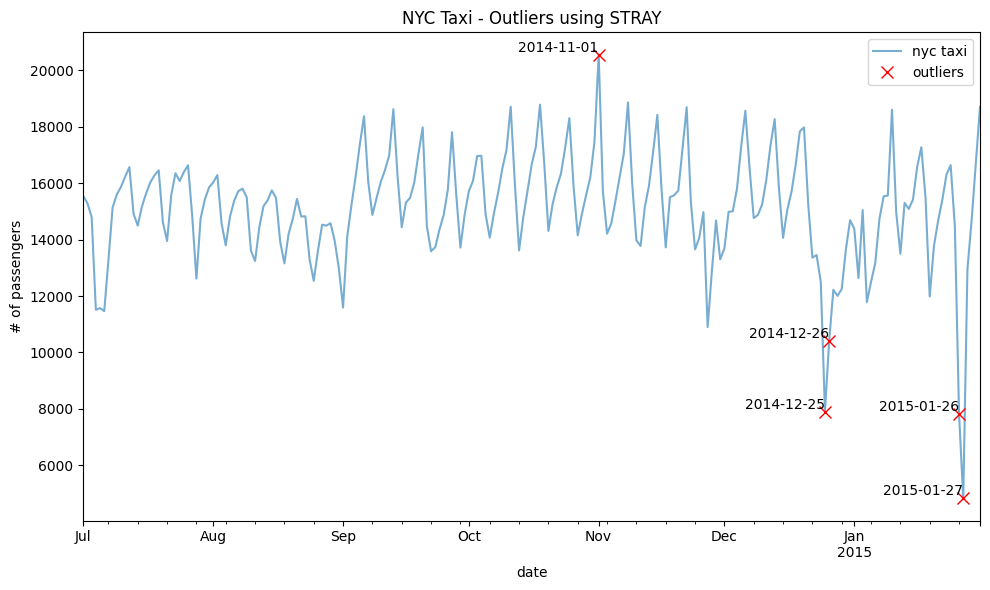

In [93]:
plot_outliers(outliers, tx, 'Outliers using STRAY', labels=True)

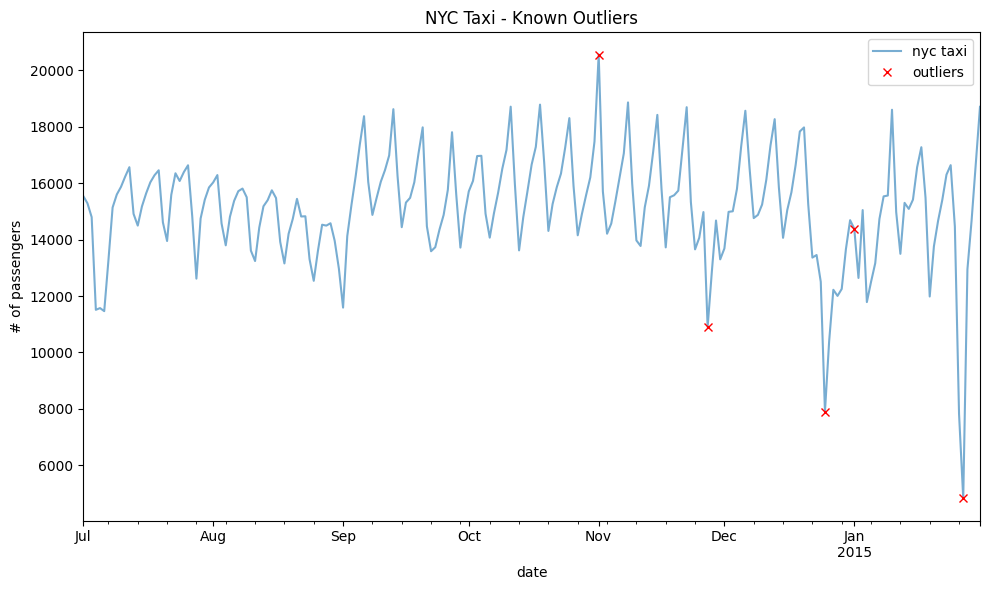

In [94]:
plot_outliers(known_outliers, tx, 'Known Outliers')

### Matrix Profile

In [95]:
from sktime.transformations.panel.matrix_profile import MatrixProfile

# Set the subsequence length (window size)
subsequence_length = 30

# Create the MatrixProfile transformer
mp_transformer = MatrixProfile(m=subsequence_length)
mp_result = mp_transformer.fit_transform(tx)

# The points with highest matrix profile values are the most anomalous
# You can set a threshold or take the top N highest values
threshold = np.percentile(mp_result, 95)  # Top 5% as anomalies
anomalies = mp_result > threshold

anomalies_series = anomalies.iloc[0]
anomaly_indices = np.where(anomalies_series)[0]

anomaly_timestamps = tx.index[anomaly_indices]

outliers = tx.loc[anomaly_timestamps]
print(outliers)

                   value
timestamp               
2014-08-09  15499.708333
2014-08-10  13607.979167
2014-08-11  13239.645833
2014-08-12  14426.500000
2014-08-13  15178.916667
2014-08-14  15394.395833
2014-11-27  10899.666667
2014-12-24  12502.000000
2014-12-25   7902.125000
2014-12-29  12250.479167


In [96]:
nyc_dates

['2014-11-01', '2014-11-27', '2014-12-25', '2015-01-01', '2015-01-27']

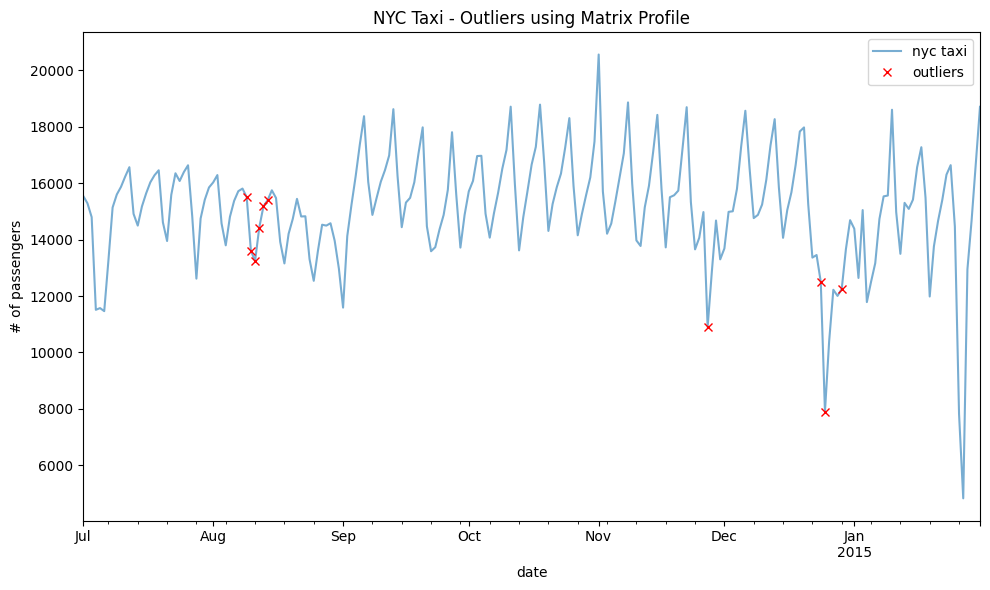

In [97]:
plot_outliers(outliers, tx, 'Outliers using Matrix Profile')